In [22]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar xf spark-3.4.0-bin-hadoop3.tgz
!pip install -q findspark pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("EcommerceBigDataProject") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()
print("Spark is ready!")
print(f"Spark version: {spark.version}")
!wget -q https://raw.githubusercontent.com/databricks/learning-spark/master/chapter2/py/src/data/flight-data/
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
print("Creating large e-commerce dataset...")
np.random.seed(42)
dates = [datetime(2023, 1, 1) + timedelta(days=x) for x in range(365)]
n_records = 1000000
data ={
    'session_id': range(1, n_records + 1),
    'user_id': np.random.randint(1, 150000, n_records),
    'visit_date': np.random.choice(dates, n_records),
    'device_type': np.random.choice(['Desktop', 'Mobile', 'Tablet'], n_records, p=[0.4, 0.5, 0.1]),
    'traffic_source': np.random.choice(['Organic', 'Paid_Search', 'Social_Media', 'Email', 'Direct'], n_records, p=[0.3, 0.2, 0.2, 0.1, 0.2]),
    'page_views': np.random.randint(1, 20, n_records),
    'session_duration': np.random.randint(30, 3600, n_records),
    'bounce_rate': np.random.choice([0, 1], n_records, p=[0.7, 0.3]),
    'conversion': np.random.choice([0, 1], n_records, p=[0.85, 0.15]),
    'revenue': np.where(np.random.choice([0, 1], n_records, p=[0.85, 0.15]),
                       np.round(np.random.uniform(20, 500, n_records), 2), 0),
    'product_category_viewed': np.random.choice(['Electronics', 'Fashion', 'Home_Garden', 'Sports', 'Books', 'Beauty'], n_records, p=[0.2, 0.2, 0.15, 0.15, 0.1, 0.2]),
    'location': np.random.choice(['USA', 'UK', 'Germany', 'France', 'India', 'Canada', 'Australia'], n_records, p=[0.3, 0.15, 0.1, 0.1, 0.1, 0.1, 0.15])
 }
df = pd.DataFrame(data)
df.to_csv('large_ecommerce_data.csv', index=False)
print(f"Created e-commerce dataset with {n_records:,} records")
ecommerce_df = spark.read.option("header", "true").option("inferSchema", "true").csv("large_ecommerce_data.csv")
print(" Data loaded successfully!")
print(f"Total records: {ecommerce_df.count():,}")
print("\nDataset Schema:")
ecommerce_df.printSchema()
print("\nFirst 10 rows:")
ecommerce_df.show(10)

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Spark is ready!
Spark version: 3.4.0
Creating large e-commerce dataset

In [24]:
# 1. Basic Statistics
print("=== BASIC STATISTICS ===")
ecommerce_df.describe(['page_views', 'session_duration', 'revenue']).show()
 # 2. Traffic Source Performance
print("\n=== TRAFFIC SOURCE PERFORMANCE ===")
traffic_performance = ecommerce_df.groupBy("traffic_source") \
    .agg({"revenue": "sum", "conversion": "sum", "session_id": "count"}) \
    .withColumnRenamed("sum(revenue)", "total_revenue") \
    .withColumnRenamed("sum(conversion)", "total_conversions") \
    .withColumnRenamed("count(session_id)", "total_sessions") \
    .orderBy("total_revenue", ascending=False)
traffic_performance.show()
 # 3. Device Type Analysis
from pyspark.sql.functions import avg, sum as spark_sum, count
print("\n=== DEVICE TYPE ANALYSIS ===")
device_analysis = ecommerce_df.groupBy("device_type") \
    .agg(spark_sum("revenue").alias("total_revenue"),
         avg("session_duration").alias("avg_session_duration"),
         spark_sum("conversion").alias("total_conversions"),
         count("session_id").alias("total_sessions")) \
    .orderBy("total_revenue", ascending=False)
device_analysis.show()
 # 4. Geographic Performance
print("\n=== GEOGRAPHIC PERFORMANCE ===")
geo_performance = ecommerce_df.groupBy("location") \
    .agg(spark_sum("revenue").alias("total_revenue"),
         avg("page_views").alias("avg_page_views"),
         spark_sum("conversion").alias("total_conversions")) \
.orderBy("total_revenue", ascending=False)
geo_performance.show()
 # 5. Product Category Insights
print("\n=== PRODUCT CATEGORY INSIGHTS ===")
category_insights = ecommerce_df.groupBy("product_category_viewed") \
    .agg(spark_sum("revenue").alias("total_revenue"),
         avg("session_duration").alias("avg_session_duration"),
         spark_sum("conversion").alias("conversions")) \
    .orderBy("total_revenue", ascending=False)
category_insights.show()
 # 6. High-Value User Analysis
print("\n=== TOP 10 HIGH-VALUE USERS ===")
top_users = ecommerce_df.groupBy("user_id") \
    .agg(spark_sum("revenue").alias("total_spent"),
         count("session_id").alias("total_sessions"),
         avg("session_duration").alias("avg_session_time")) \
    .orderBy("total_spent", ascending=False) \
    .limit(10)
top_users.show()

=== BASIC STATISTICS ===
+-------+-----------------+------------------+------------------+
|summary|       page_views|  session_duration|           revenue|
+-------+-----------------+------------------+------------------+
|  count|          1000000|           1000000|           1000000|
|   mean|        10.010055|       1814.506394| 38.93680840000025|
| stddev|5.474640980801318|1030.7077233976268|107.18288409258898|
|    min|                1|                30|               0.0|
|    max|               19|              3599|             500.0|
+-------+-----------------+------------------+------------------+


=== TRAFFIC SOURCE PERFORMANCE ===
+--------------+--------------------+--------------+-----------------+
|traffic_source|       total_revenue|total_sessions|total_conversions|
+--------------+--------------------+--------------+-----------------+
|       Organic|1.1684977739999969E7|        300088|            45067|
|  Social_Media|   7831499.899999999|        199797|        

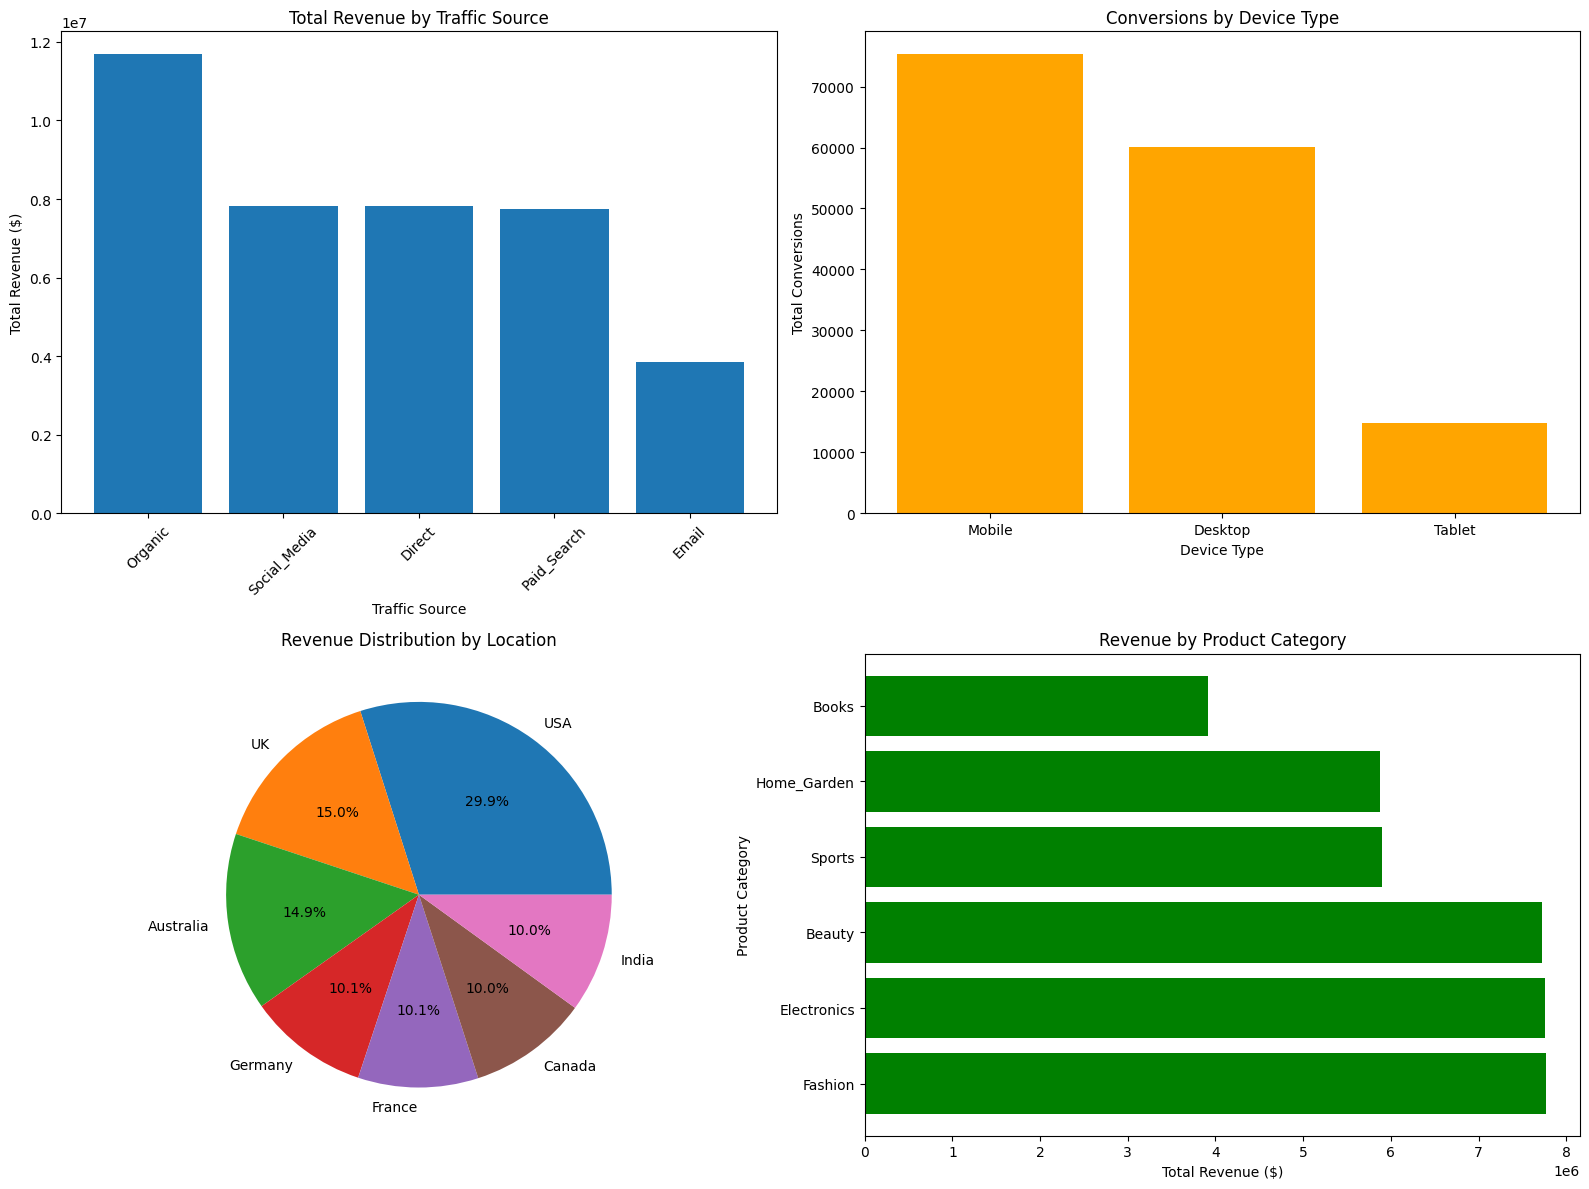

 Visualizations created and saved!


In [25]:
!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns
 # Convert Spark DataFrames to Pandas for plotting
traffic_performance_pd = traffic_performance.toPandas()
device_analysis_pd = device_analysis.toPandas()
geo_performance_pd = geo_performance.toPandas()
category_insights_pd = category_insights.toPandas()
 # Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
 # 1. Revenue by Traffic Source
axes[0,0].bar(traffic_performance_pd['traffic_source'], traffic_performance_pd['total_revenue'])
axes[0,0].set_title('Total Revenue by Traffic Source')
axes[0,0].set_xlabel('Traffic Source')
axes[0,0].set_ylabel('Total Revenue ($)')
axes[0,0].tick_params(axis='x', rotation=45)
 # 2. Device Type Performance
axes[0,1].bar(device_analysis_pd['device_type'], device_analysis_pd['total_conversions'], color='orange')
axes[0,1].set_title('Conversions by Device Type')
axes[0,1].set_xlabel('Device Type')
axes[0,1].set_ylabel('Total Conversions')
 # 3. Geographic Distribution
axes[1,0].pie(geo_performance_pd['total_revenue'], labels=geo_performance_pd['location'], autopct='%1.1f%%')
axes[1,0].set_title('Revenue Distribution by Location')

 # 4. Product Category Revenue
axes[1,1].barh(category_insights_pd['product_category_viewed'], category_insights_pd['total_revenue'], color='green')
axes[1,1].set_title('Revenue by Product Category')
axes[1,1].set_xlabel('Total Revenue ($)')
axes[1,1].set_ylabel('Product Category')
plt.tight_layout()
plt.savefig('ecommerce_analysis_results.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Visualizations created and saved!")

In [26]:
print("="*60)
print("E-COMMERCE BIG DATA ANALYSIS SUMMARY REPORT")
print("="*60)
total_records = ecommerce_df.count()
total_revenue = ecommerce_df.agg({"revenue": "sum"}).collect()[0][0]
total_conversions = ecommerce_df.agg({"conversion": "sum"}).collect()[0][0]
conversion_rate = (total_conversions / total_records) * 100
avg_session_duration = ecommerce_df.agg({"session_duration": "avg"}).collect()[0][0]
print(f"Dataset Overview:")
print(f"   • Total Sessions Processed: {total_records:,}")
print(f"   • Total Revenue Generated: ${total_revenue:,.2f}")
print(f"   • Total Conversions: {total_conversions:,}")
print(f"   • Overall Conversion Rate: {conversion_rate:.2f}%")
print(f"   • Average Session Duration: {avg_session_duration:.0f} seconds")
print(f"\nKey Insights:")
top_traffic_source = traffic_performance.first()
print(f"   • Best Traffic Source: {top_traffic_source['traffic_source']}")
print(f"   • Top Source Revenue: ${top_traffic_source['total_revenue']:,.2f}")
top_device = device_analysis.first()
print(f"   • Best Performing Device: {top_device['device_type']}")
print(f"   • Top Device Revenue: ${top_device['total_revenue']:,.2f}")
top_location = geo_performance.first()
print(f"   • Best Market: {top_location['location']}")
print(f"   • Top Market Revenue: ${top_location['total_revenue']:,.2f}")
print(f"\nTechnology Used:")
print(f"   • Apache Spark {spark.version}")
print(f"   • PySpark for data processing")
print(f"   • Processed on Google Colab")
print(f"   • Domain: E-commerce Customer Behavior Analytics")
print("="*60)

E-COMMERCE BIG DATA ANALYSIS SUMMARY REPORT
Dataset Overview:
   • Total Sessions Processed: 1,000,000
   • Total Revenue Generated: $38,936,808.40
   • Total Conversions: 150,198
   • Overall Conversion Rate: 15.02%
   • Average Session Duration: 1815 seconds

Key Insights:
   • Best Traffic Source: Organic
   • Top Source Revenue: $11,684,977.74
   • Best Performing Device: Mobile
   • Top Device Revenue: $19,554,336.19
   • Best Market: USA
   • Top Market Revenue: $11,648,915.38

Technology Used:
   • Apache Spark 3.4.0
   • PySpark for data processing
   • Processed on Google Colab
   • Domain: E-commerce Customer Behavior Analytics
